In [1]:
## sleep stage classification - 2 class - using stat features on segments of raw signal 

# try :
# balance with smote / balanced class weight in SVM
# grid search + CV  -> show plots on train & val error
# optimise prob thres

# http://localhost:8888/notebooks/Intern/Sleep_stage_Classification_2Class-imbalanced-data-SMOTE.ipynb
# http://localhost:8888/notebooks/GPU_run/EEG_Classification_CNN_full_SMOTE_diff_network_GPU.ipynb
# http://localhost:8888/notebooks/classification_2class_epochData_newPkl.ipynb

import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
import itertools
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.metrics import auc,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix
from sklearn.metrics import classification_report

In [2]:
###################function to plot confusion matrix#####################################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
###########################################################################################

In [3]:
## load data ##

file_location='C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data' #C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018'
os.chdir('C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data') #'/home/intern_eyecare/Desktop/EEG/raw_data') #C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018')

# remove 2nd night of subject 13, as there was data loss - pkl file created accordingly
dfull = pickle.load(open('eeg_statistical_feature_vector.pkl', 'rb'))
dfull.head(5)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,patient_id,day,epoch,class
0,-121.576557,76.190476,-0.416508,1.687912,-17.230769,24.240293,41.471062,36.587040,-114.637363,156.553846,...,6.245118,4.547985,-13.737729,25.013919,38.751648,31.304390,400,1,s1e1,wake
1,-94.945055,33.054945,-0.898657,0.703297,-6.704762,7.454945,14.159707,16.226144,-67.750916,40.275458,...,-1.548972,-4.547985,-25.295238,23.888645,49.183883,32.831691,400,1,s1e2,wake
2,-69.532601,77.221978,0.975082,-0.984615,-10.127473,12.635897,22.763370,21.954602,-62.874725,79.566300,...,0.635624,3.000733,-14.792674,20.700366,35.493040,27.585531,400,1,s1e3,wake
3,-58.561172,50.027839,-2.881641,-2.391209,-18.754579,13.761172,32.515751,22.161343,-43.651282,33.805128,...,-0.064078,0.468864,-11.229304,11.698168,22.927473,15.383105,400,1,s1e4,wake
4,-48.621245,37.743590,-0.967736,1.734799,-14.816117,13.034432,27.850549,18.337279,-33.336264,34.461538,...,0.517158,0.750183,-11.838828,10.549451,22.388278,21.240018,400,1,s1e5,wake


In [4]:
### check the data ###
# 1. look for null values
dfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92994 entries, 0 to 92993
Data columns (total 44 columns):
0             92994 non-null float64
1             92994 non-null float64
2             92994 non-null float64
3             92994 non-null float64
4             92994 non-null float64
5             92994 non-null float64
6             92994 non-null float64
7             92994 non-null float64
8             92994 non-null float64
9             92994 non-null float64
10            92994 non-null float64
11            92994 non-null float64
12            92994 non-null float64
13            92994 non-null float64
14            92994 non-null float64
15            92994 non-null float64
16            92994 non-null float64
17            92994 non-null float64
18            92994 non-null float64
19            92994 non-null float64
20            92994 non-null float64
21            92994 non-null float64
22            92994 non-null float64
23            92994 non-null float64
24 

In [5]:
dfull.isnull().sum()

0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             0
10            0
11            0
12            0
13            0
14            0
15            0
16            0
17            0
18            0
19            0
20            0
21            0
22            0
23            0
24            0
25            0
26            0
27            0
28            0
29            0
30            0
31            0
32            0
33            0
34            0
35            0
36            0
37            0
38            0
39            0
patient_id    0
day           0
epoch         0
class         0
dtype: int64

In [6]:
# 2. check data distribution
dfull.groupby('class').size()

class
sleep_stage_1     2804
sleep_stage_2    17799
wake             72391
dtype: int64

In [7]:
### convert from 3-class to 2-class ###
dfull['class2'] = dfull['class']
dfull['class2'] = [0 if x == 'wake' else 1 for x in dfull['class2']]

## convert selected columns to string/categories 
## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search
dfull[['class']] = dfull[['class']].astype('str')        # ,'class2'

In [ ]:
### create training & test sets ###

In [8]:
### by patient ID  ###
ID = dfull['patient_id'].unique() # create ID list

np.random.seed(456)   ## select the IDs for the 2 sets
msk = np.random.rand(len(ID)) < 0.8
trainIDs = pd.DataFrame()
testIDs = pd.DataFrame()
trainIDs['patient_id'] = ID[msk]
testIDs['patient_id'] = ID[~msk]
print(trainIDs['patient_id'].tolist())
print(testIDs['patient_id'].tolist())


Train = dfull.loc[dfull['patient_id'].isin(ID[msk])] # create the train-test sets
Test = dfull.loc[dfull['patient_id'].isin(ID[~msk])] #
print(Train.shape)
print(Test.shape)
## also, check the distribution of class 0 & 1 in the train & test sets
print('Train distribution')
print(Train.groupby('class2').size())
print('')
print('Test distribution')
print(Test.groupby('class2').size())


X_train1 = Train.drop(['patient_id','day','epoch','class','class2'], 1).reset_index()  ## create X & y splits
X_test = Test.drop(['patient_id','day','epoch','class','class2'], 1).reset_index()
y_train1 = Train['class2'].reset_index()
y_test = Test['class2'].reset_index()
X_train1 = X_train1.drop(['index'], 1)
X_test = X_test.drop(['index'],1)
y_train1 = y_train1.drop(['index'],1)
y_test = y_test.drop(['index'],1)

['400', '401', '402', '404', '405', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419']
['403', '406']
(82992, 45)
(10002, 45)
Train distribution
class2
0    64350
1    18642
dtype: int64

Test distribution
class2
0    8041
1    1961
dtype: int64


In [ ]:
'''
### by random sampling ###
X =  dfull.drop(['pID','day','epoch','class_label','class2'], 1) # dfull[['delta','theta','alpha','beta','gamma']]
y =  dfull['class2'] 

X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  #stratify=y) #stratify=True

# to test if split is stratified
y_tr = pd.DataFrame(y_train1)
y_ts = pd.DataFrame(y_test)
print('')
print(y_tr.groupby('class2').size())
print('')
print(y_ts.groupby('class2').size())
'''

In [ ]:
'''
## upsample training set
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train1, y_train1)
'''

In [ ]:
'''
check_upsample = pd.DataFrame(y_train)
check_upsample.columns = ['class2']
#check_upsample.head(2)
print(check_upsample.groupby('class2').size())'''

In [9]:
### data scaling ###
from sklearn.preprocessing import StandardScaler  #, MinMaxScaler, RobustScaler
# http://benalexkeen.com/feature-scaling-with-scikit-learn/
# standardscaler: suitable for normally distributed data
# minMaxScaler: (x-min)/(max - min)

## normalize the data  : can also use other scalers 
scaler = StandardScaler()  #MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled.shape

In [ ]:
## -----------------------------------------------------------------------------------------##

In [ ]:
##########  SVC model + class weight balancing #####W#

In [10]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-18 12:01:25


In [11]:
model_svc = SVC(class_weight='balanced')  # probability=True
model_svc.fit(X_train_scaled, y_train1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [12]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-18 12:07:14


In [13]:
# predict on test data - check metrics
y_pred = model_svc.predict(X_test_scaled)

Normalized confusion matrix
[[0.87 0.13]
 [0.13 0.87]]


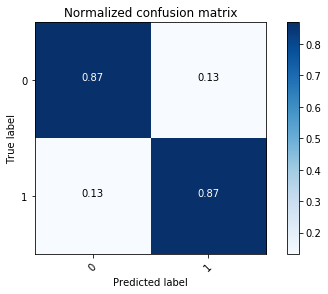

In [14]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [15]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

(array([0.96, 0.62]),
 array([0.87, 0.87]),
 array([0.91, 0.72]),
 array([8041, 1961], dtype=int64))

In [16]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      8041
           1       0.62      0.87      0.72      1961

   micro avg       0.87      0.87      0.87     10002
   macro avg       0.79      0.87      0.82     10002
weighted avg       0.90      0.87      0.88     10002



In [17]:
### --------------------------------------------------------
## default SVC
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-18 12:54:28


In [18]:
model_svc = SVC()  # probability=True
model_svc.fit(X_train_scaled, y_train1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [19]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-18 12:57:56


In [20]:
# predict on test data - check metrics
y_pred = model_svc.predict(X_test_scaled)

Normalized confusion matrix
[[0.95 0.05]
 [0.29 0.71]]


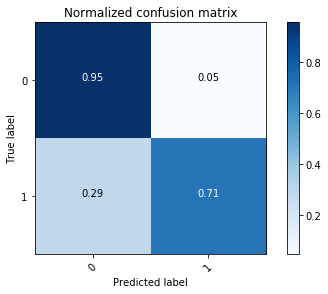

In [21]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [22]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

(array([0.93, 0.79]),
 array([0.95, 0.71]),
 array([0.94, 0.75]),
 array([8041, 1961], dtype=int64))

In [23]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      8041
           1       0.79      0.71      0.75      1961

   micro avg       0.91      0.91      0.91     10002
   macro avg       0.86      0.83      0.84     10002
weighted avg       0.90      0.91      0.90     10002



In [ ]:
##---------------------------------------------------------------------------------------------------

In [ ]:
### SVC model + probability thresholding ###
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
model_svc = SVC(probability=True)  #, class_weight='balanced')
model_svc.fit(X_train_scaled, y_train1)

In [ ]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
# predict on test data - check metrics
y_pred = model_svc.predict(X_test_scaled)
#y_pred = model_svc.predict_proba(X_test_scaled)

In [ ]:
y_pred

In [ ]:
model_svc.predict_proba(X_test_scaled)
# predict_proba gives you the probabilities for the target (0 and 1 in your case) in array form. 
# The number of probabilities for each row is equal to the number of categories in target variable (2 in your case)

In [ ]:
model_svc

In [ ]:
y_pred = model_svc.predict_proba(X_test_scaled)[:,[1]]  ## prob for class 1

In [ ]:
# vary threshold & get metrics

cut_off=np.arange(0,1,.01)

metric = []
#sensitivity=[]
#specificity=[]
for m in cut_off:
    array=np.zeros(len(y_pred))
    array_ind=[i for i in range(len(y_pred)) if y_pred[i]>=m]
    array[array_ind]=1
    p=precision_recall_fscore_support(y_test,array) 
    sensitivity = p[1][1]  # sensitivity.append(p[1][1])
    specificity = p[1][0]  # specificity.append(p[1][0])
    metric.append([m,sensitivity, specificity])
#sensitivity=pd.DataFrame(np.array(sensitivity))
#specificity=pd.DataFrame(np.array(specificity))
metric = pd.DataFrame(metric,columns=['thres', 'sensitivity', 'specificity'])

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(x=1-pd.np.array(metric.iloc[:,[2]]),y=pd.np.array(metric.iloc[:,[1]]))
auc(1-pd.np.array(metric.iloc[:,[2]]),pd.np.array(metric.iloc[:,[1]]))

In [ ]:
metric['FPR'] = 1 - metric['specificity']
#print(metric)
metric.head(50)

In [ ]:
metric.tail(51)

In [ ]:
# Youden index = x at which max(sensitivity + (1-specificity))  ## CORRECT FORMULA ??
optimal_idx = np.argmax(pd.np.array(metric['sensitivity']) - pd.np.array(metric['FPR']))
optimal_threshold = cut_off[optimal_idx]
print(optimal_threshold)

In [ ]:
y_pred_thres = np.where(y_pred > optimal_threshold, 1, 0)

In [ ]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred_thres)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_thres, target_names=class_names))

In [ ]:
print(accuracy_score(y_test,y_pred))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred_thres) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

In [ ]:
p = precision_recall_fscore_support(y_test,y_pred_thres) 
sen = p[1][1]
spec = p[1][0]
print('sen: ' + str(sen) +' , spec: ' + str(spec))

In [ ]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_test, y_pred)

In [ ]:
df = pd.DataFrame()
df = pd.concat([df,pd.DataFrame(thresholds), pd.DataFrame(p), pd.DataFrame(r)], axis=1)
df.columns = ['threshold', 'precision', 'recall']

In [ ]:
df.describe()

In [ ]:
df[ (df['precision'] == df['recall'] ) ] 

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Threshold")
    plt.legend(loc='best')

plot_precision_recall_vs_threshold(p, r, thresholds)

In [ ]:
y_pred_thres2 = np.where(y_pred > 0.306, 1, 0)
print(classification_report(y_test, y_pred_thres2, target_names=class_names))

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_thres2)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
## --------------------------------------------------------------------------------------------

In [ ]:
###  cross-validation + Thresholding ###

from sklearn.metrics import make_scorer,recall_score,accuracy_score,precision_score   #roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold   # train_test_split,

clf = SVC() #n_jobs=-1)  # this runs the computation in parallel

param_grid = [
  #{'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
]


scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}


skf = StratifiedKFold(n_splits=4)  # n_splits=10
grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit='recall_score',
                           cv=skf, return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train1)  #X_train.values, y_train.values)

grid_search.best_params_
#best_C=grid_search.best_params_['C']
#best_gamma=grid_search.best_params_['gamma']

In [ ]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
refit_score = 'recall_score'
print('Best params for {}'.format(refit_score))

In [ ]:
grid_search.cv_results_

In [ ]:
## job started around 8 or 8:30 PM
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
model_svc = SVC(probability=True, C= 10, gamma= 0.1, kernel= 'rbf')  #, class_weight='balanced')
model_svc.fit(X_train_scaled, y_train1)

In [ ]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
y_pred = model_svc.predict_proba(X_test_scaled)[:,[1]]  ## prob for class 1

In [ ]:
# vary threshold & get metrics

cut_off=np.arange(0,1,.01)

metric = []
#sensitivity=[]
#specificity=[]
for m in cut_off:
    array=np.zeros(len(y_pred))
    array_ind=[i for i in range(len(y_pred)) if y_pred[i]>=m]
    array[array_ind]=1
    p=precision_recall_fscore_support(y_test,array) 
    sensitivity = p[1][1]  # sensitivity.append(p[1][1])
    specificity = p[1][0]  # specificity.append(p[1][0])
    metric.append([m,sensitivity, specificity])
#sensitivity=pd.DataFrame(np.array(sensitivity))
#specificity=pd.DataFrame(np.array(specificity))
metric = pd.DataFrame(metric,columns=['thres', 'sensitivity', 'specificity'])

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(x=1-pd.np.array(metric.iloc[:,[2]]),y=pd.np.array(metric.iloc[:,[1]]))
auc(1-pd.np.array(metric.iloc[:,[2]]),pd.np.array(metric.iloc[:,[1]]))

In [ ]:
metric['FPR'] = 1 - metric['specificity']
#print(metric)
metric.head(50)

In [ ]:
metric.tail(51)

In [ ]:
optimal_idx = np.argmax(pd.np.array(metric['sensitivity']) - pd.np.array(metric['FPR']))
optimal_threshold = cut_off[optimal_idx]
print(optimal_threshold)

y_pred_thres = np.where(y_pred > optimal_threshold, 1, 0)

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_thres)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred_thres) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

In [ ]:
## -----------------------------------------------------------------------------------------------------------

In [ ]:
### balanced classweight + grid parameters ####
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
model_svc = SVC(C= 10, gamma= 0.1, kernel= 'rbf', class_weight='balanced')  # probability=True,
model_svc.fit(X_train_scaled, y_train1)

In [ ]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
# predict on test data - check metrics
y_pred = model_svc.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

In [ ]:
####  balanced class weight + grid param + prob thres  ####

In [ ]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
model_svc_bl = SVC(C= 10, gamma= 0.1, kernel= 'rbf', class_weight='balanced', probability=True)
model_svc_bl.fit(X_train_scaled, y_train1)

In [ ]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
y_pred = model_svc_bl.predict_proba(X_test_scaled)[:,[1]]  ## prob for class 1

In [ ]:
# vary threshold & get metrics

cut_off=np.arange(0,1,.01)

metric = []
#sensitivity=[]
#specificity=[]
for m in cut_off:
    array=np.zeros(len(y_pred))
    array_ind=[i for i in range(len(y_pred)) if y_pred[i]>=m]
    array[array_ind]=1
    p=precision_recall_fscore_support(y_test,array) 
    sensitivity = p[1][1]  # sensitivity.append(p[1][1])
    specificity = p[1][0]  # specificity.append(p[1][0])
    metric.append([m,sensitivity, specificity])
#sensitivity=pd.DataFrame(np.array(sensitivity))
#specificity=pd.DataFrame(np.array(specificity))
metric = pd.DataFrame(metric,columns=['thres', 'sensitivity', 'specificity'])

In [ ]:
metric['FPR'] = 1 - metric['specificity']

optimal_idx = np.argmax(pd.np.array(metric['sensitivity']) - pd.np.array(metric['FPR']))
optimal_threshold = cut_off[optimal_idx]
print(optimal_threshold)

y_pred_thres = np.where(y_pred > optimal_threshold, 1, 0)

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_thres)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred_thres) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

In [ ]:
#print(metric)
metric.head(51)

In [ ]:
metric.tail(50)

In [ ]:
########################### END ######################

In [ ]:
## plotted 16 PCs, checked with top 6 PCs - sensitivity reduces even more

from sklearn import decomposition
pca = decomposition.PCA(n_components = 16)  # n_components = N; should be <= #features
pca.fit(X_train1)
X_train_pca = pca.transform(X_train1)
print(pca.explained_variance_ratio_)

In [ ]:
pca_var = pca.explained_variance_ratio_ 
indices = np.argsort(pca_var)[::-1]
# Plot the PC variances
plt.figure()
plt.title("PCA variances")
plt.bar(range(X_train_pca.shape[1]), pca_var[indices],
       color="r", align="center")
plt.xticks(range(X_train_pca.shape[1]), indices)
plt.xlim([-1, X_train_pca.shape[1]])
plt.show()

In [ ]:
pca = decomposition.PCA(n_components = 6)  # n_components = N; should be <= #features
pca.fit(X_train1)
X_train_pca = pca.transform(X_train1)

X_test_pca = pca.transform(X_test)

In [ ]:
model_svc_pca = SVC()
model_svc_pca.fit(X_train_pca, y_train1)

In [ ]:
# predict on test data - check metrics
y_pred_pca = model_svc_pca.predict(X_test_pca)

In [ ]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred_pca)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
############## not checked beyond this #############

In [ ]:
#### model parameters changed ####

In [ ]:
model_svc2 = SVC(C=5, gamma=1)
model_svc2.fit(X_train_scaled, y_train1)

In [ ]:
# predict on test data - check metrics
y_pred2 = model_svc2.predict(X_test_scaled)

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()